# Threshold search procedures with asymmetric-cost evaluation functions 

## Rationale

We wish to find the optimal iterative procedure to find an neuron's excitation threshold (i.e. stimulus intensity) for a specific stimulation protocol.

At first glance, that problem looks well suited for a classic binary search procedure, with a few extra-requirements:
- **efficient across a wide range of orders of magnitudes**: excitation thresholds can vary by several orders of magnitude depending on cell type and stimulus protocol. We need a method that can efficient find threshold for all these conditions
- **guarantees bounded absolute and relative error**: the method must guarantee that computed thresholds are accurate across several orders of magnitude (i.e. relative accuracy), but also independently of the threshold value itself (i.e. absolute accuracy)
- **avoids numerous supra-threshold evaluations**: in the context of neuron models, condition evaluation is performed by simulating the neural response to a stimulus at a particular intensity and checking for excitation. Such evaluations typically show an increase in computation time for active neural responses (i.e. for evaluations above the threshold). Hence, in order to reduce the overall computational cost of search procedures, we should minimize the number of supra-threshold evaluations.
- **guarantees that the returned threshold satisfies the condition of excitation**: the search procedure can only approach the exact excitation threshold down to a given error margin. Hence, as the algorithm converges towards the target value, we need to make sure that it stops only if convergence is achieved AND the final value yields excitation. 
- **efficiently handles cases in which no threshold lies within the search interval**: in practice, we are often limited in the extent of the search interval we can provide. Hence, it is very possible that for some conditions, no excitation threshold exists within the predefined range. In such cases, we should (1) return an NaN value and (2) avoid numerous iterations.

### Imports

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt

from PySONIC.utils import logger, isWithin
from PySONIC.threshold import threshold
from PySONIC.constants import *

logger.setLevel(logging.INFO)

### Evaluation function

Let's design a function to assess the efficiency of a search procedure within a specific interval. It will run the search procedure for artificial evaluation functions with threshold values logarithmically space along the interval, and one additional out-of-bounds value on each side. For each target, the function will record:
- the final computed threshold, along with the maximal evaluated value along the search procedure
- the absolute and relative errors in the computed threshold
- the number of function evaluations along the search procedure to reach convergence, along with the number of supra-threshold evaluations

In [2]:
def evaluateThreshold(xref, xbounds, x0, eps_thr, rel_eps_thr, precheck, fbound):
    ''' Evaluate the performance of the threshold finding function for a specific search interval,
        initial value, absolute and relative thresholds, and search criteria.
    ''' 
    title = []
    if fbound is not None:
        title.append(f'bounding factor: {fbound}')    
    if precheck:
        title.append('pre-check ON')

    # Create figure
    fig, axes = plt.subplots(4, 1, figsize=(8, 10))
    if len(title) > 0:
        axes[0].set_title(' - '.join(title))
    axes[-1].set_xlabel('target')
    axes[0].set_ylabel('value')
    axes[1].set_ylabel('abs. $\epsilon$')
    axes[2].set_ylabel('rel. $\epsilon$ (%)')
    axes[3].set_ylabel('# iterations')
    for i in [0, 1]:
        axes[i].set_yscale('log')
    axes[3].set_ylim(0, 50)
    for ax in axes:
        ax.set_xscale('log')
        ax.set_xlim(xref.min() / 2, xref.max() * 2)
        ax.axvline(xbounds[0], c='k', label='bounds')
        ax.axvline(xbounds[1], c='k')
        ax.axvline(x0, ls='--', c='k', label='initial value')
    if eps_thr is not None:
        axes[1].axhline(eps_thr, ls='--', c='g', label='absolute threshold')
    if rel_eps_thr is not None:
        axes[2].axhline(rel_eps_thr * 1e2, ls='--', c='g', label='relative threshold')

    # Run binary search for each random sample
    nx = len(xref)
    xout = np.zeros(nx)
    nit = np.zeros(nx)
    nit_supra = np.zeros(nx)
    xmax = np.zeros(nx)
    xnan = []
    for i, xr in enumerate(xref):
        x, is_above = threshold(
            lambda x: x >= xr, xbounds, x0=x0, eps_thr=eps_thr, rel_eps_thr=rel_eps_thr,
            precheck=precheck, fbound=fbound, output_history=True)
        if np.isnan(x[-1]):
            xnan.append(xr)
        xout[i] = x[-1] 
        xmax[i] = np.nanmax(x)
        nit[i] = x.size
        nit_supra[i] = sum(x > xr)

    # Evaluate errors
    abs_err = np.abs(xout - xref)
    rel_err = abs_err / xref

    # Plot outputs
    axes[0].plot(xref, xout, label='final value')
    axes[0].plot(xref, xmax, label='max explored value')
    axes[1].plot(xref, abs_err)
    axes[2].plot(xref, rel_err * 1e2)
    axes[3].plot(xref, nit, label='overall')
    axes[3].plot(xref, nit_supra, label='supra-threshold')

    # Post-process figure
    axes[0].axhline(x[0], ls='--', c='k')
    for ax in axes:
        for i, xn in enumerate(xnan):
            ax.axvline(xn, ls='--', c='r', label='outliers' if i == 0 else None)            
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    for ax in axes[:-1]:
        ax.set_xticklabels([])

    return fig

# Generic case-study

Let's define some benchmark parameters:
- a very wide search interval spanning several (10) orders of magnitude
- a 1% relative error threshold
- an absolute error threshold at the geometric mean of the bounds of the search interval

In [3]:
xbounds = (1e-5, 1e5)                       # initial search interval
rel_eps_thr = 1e-2                          # relative error threshold
eps_thr = np.sqrt(xbounds[0] * xbounds[1])  # absolute error threshold

# evaluation points
xref = np.logspace(*np.log10(np.array(xbounds)), 10000)  
xref[0] /= 2
xref[-1] *= 2

## Naive approach

We'll start with a very naive approach: standard binary search procedure, progressively refining the search interval with evaluation starting at the middle point (i.e. arithmetic mean) of the interval bounds

 29/04/2020 22:40:42: No threshold found within the [1.00e-05 - 1.00e+05] interval
C:\Users\lemaire\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater
 29/04/2020 22:40:44: No threshold found within the [1.00e-05 - 1.00e+05] interval


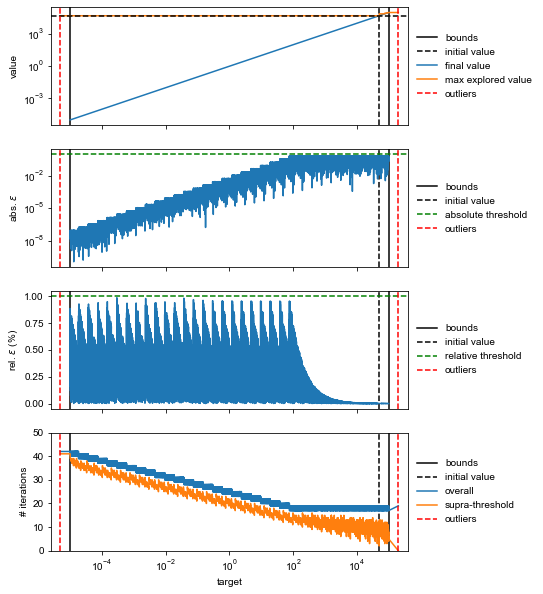

In [4]:
x0 = np.mean(xbounds)
precheck = False
fbound = None
fig = evaluateThreshold(xref, xbounds, x0, eps_thr, rel_eps_thr, precheck, fbound)

We can make several observations:
- the initial evaluation (arithmetic mean) falls quite high in the logarithmic scale of the search interval.
- the maximal explored value is the initial value for most of the range, and can be quite high above the target value
- the absolute error in computed threshold increases with the target value (as a result of the higher relative error threshold) until it reaches the absolute error threshold, at which points it flattens
- the relative error in computed threshold follows a sawtooth profile with a of $2^n$ times the lower bound (staying below the specified threshold) until it the absolute error criterion, at which point it starts decreasing
- the number of iterations is highest (up to 40+ iterations) for smallest thresholds (as a result of the high initial evaluation value being far away from the target), decreases for larger targets and then flattens (around 20-25 iterations) for larger target thresholds, once the absolute error criterion predominates. This global variation is modulated by short range fluctuations, that are caused by the need to return a value that satisfies the excitation condition.
- overall, the number of supra-threshold evaluations is slightly smaller than the overall number of iterations (3-5 less). It is highest for the smallest targets, and decreases as the target value increases. Interestingly, it does not flatten for large targets, and thus becomes significantly smaller than the overall number of iterations.
- a significant number of iterations is required to find outliers larger than the upper bound (about the same as for targets just below the upper bound). The situation is even worse for outliers smaller than the lower bound, requiring as many iterations as for the smallest targets in the interval, all of them being supra-threshold.

**Objectives**:
- decrease the max number of iterations (overall and supra-threshold)
- decrease the the max explored value across the search interval
- limit the number of iterations required to detect outliers

## Refined initial value

As a first step, we can set the initial evaluation at the geometric mean of the the bounds of the search interval, in order to decrease the max log2-distance across the search range. 

 29/04/2020 22:40:45: No threshold found within the [1.00e-05 - 1.00e+05] interval
C:\Users\lemaire\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater
 29/04/2020 22:40:46: No threshold found within the [1.00e-05 - 1.00e+05] interval


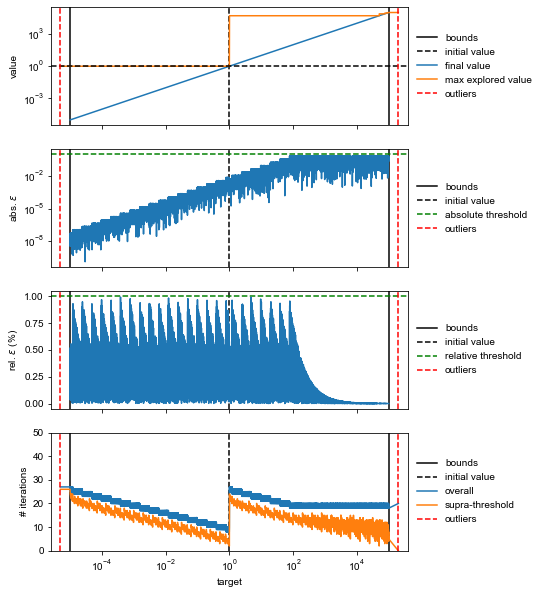

In [5]:
x0 = np.sqrt(xbounds[0] * xbounds[1])
precheck = False
fbound = None
fig = evaluateThreshold(xref, xbounds, x0, eps_thr, rel_eps_thr, precheck, fbound)

As we can see, the considerable shift in the initial value (decrease by several orders of magnitude) splits the logarithmic space more evenly. This has several consequences:
- the maximum log2-distance to a target (the smallest value) is reduced, which **decreases the maximum number of iterations across the whole search range** (both overall and supra-threshold). 
- the **maximum explored value is reduced** as a result of this more even split (geometric mean $q$ for targets $x \leq q$, half the upper bound $ub$ for targets $q \leq x \leq ub / 2$, and a neighbor of the final value for targets $x \geq ub/2$).
- the paradigm introduces a **sharp transition in the number of required iterations** (overall and supra-threshold) as the target crosses the initial value. Such a discontinuity should be avoided. 

## Pre-bounding

Let's try another approach, so-called *pre-bounding*. Prior to starting the binary search, we perform another search in which the value is updated more drastically (multiplied or divided by a factor $f$, typically 2), until the upper bound effectively becomes $f$ times the lower bound. 

### Arithmetic mean
Let's first try with the naive, arithmetic mean as initial evaluation value:

 29/04/2020 22:40:47: No threshold found within the [1.00e-05 - 1.00e+05] interval
C:\Users\lemaire\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater
 29/04/2020 22:40:49: No threshold found within the [1.00e-05 - 1.00e+05] interval


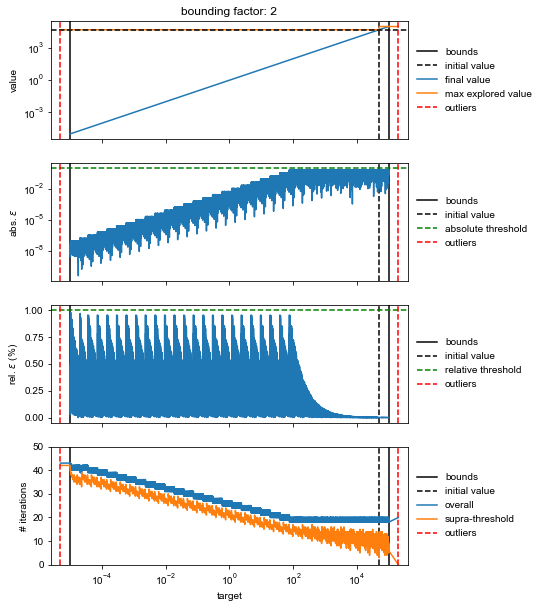

In [6]:
x0 = np.mean(xbounds)
precheck = False
fbound = 2
fig = evaluateThreshold(xref, xbounds, x0, eps_thr, rel_eps_thr, precheck, fbound)

Using the arithmetic mean as the initial value, the pre-bounding does not significantly improve the procedure's efficiency:
- if anything, the max number of required iterations across the search range increases slightly
- the number of required supra-threshold iterations stays similar
- the maximum evaluated value is still way above the target in most cases

### Geometric mean
Let's now try with the geometric mean as initial evaluation value, and compare the efficiency of different bounding factors:

 29/04/2020 22:40:50: No threshold found within the [1.00e-05 - 1.00e+05] interval
C:\Users\lemaire\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater
 29/04/2020 22:40:51: No threshold found within the [1.00e-05 - 1.00e+05] interval
 29/04/2020 22:40:51: No threshold found within the [1.00e-05 - 1.00e+05] interval
C:\Users\lemaire\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater
 29/04/2020 22:40:53: No threshold found within the [1.00e-05 - 1.00e+05] interval
 29/04/2020 22:40:53: No threshold found within the [1.00e-05 - 1.00e+05] interval
C:\Users\lemaire\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater
 29/04/2020 22:40:54: No threshold found within the [1.00e-05 - 1.00e+05] interval


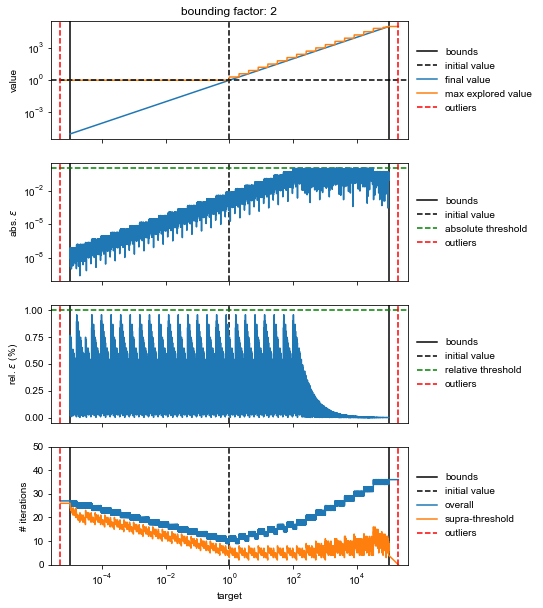

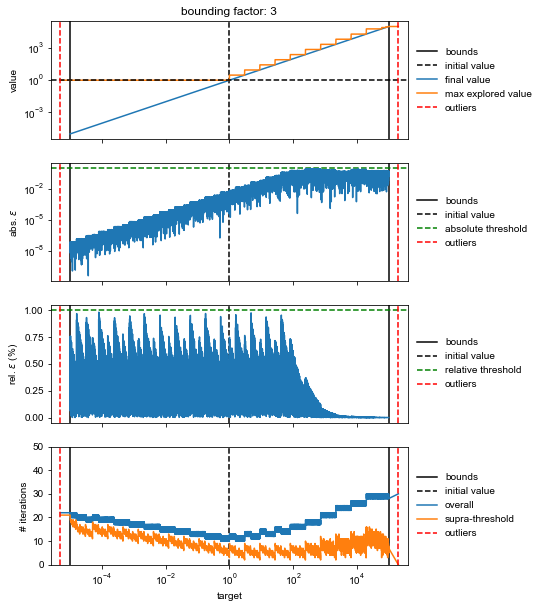

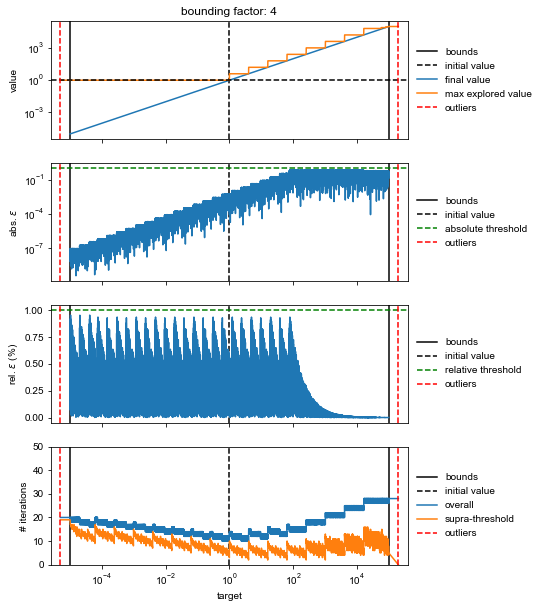

In [7]:
x0 = np.sqrt(xbounds[0] * xbounds[1])
precheck = False
for fbound in [2, 3, 4]:
    fig = evaluateThreshold(xref, xbounds, x0, eps_thr, rel_eps_thr, precheck, fbound)

As we can see, the combined use of geometric mean and pre-bounding has several positive effects:
- for targets below the geometric mean, the profiles of max evaluation value and number of iterations (both overall and supra-threshold) are very similar.
- **for targets above the geometric mean**, the overall number of iterations starts increasing, however the **number of supra-threshold iterations stays fairly low**.
- there is **no sharp transition in number of iterations** as the target crosses the geometric mean 

Moreover, different bounding factors seem to give similar results in terms of number of iterations: the initial search takes less iterations to converge with higher $f$, but then yields a larger interval for the second, standard binary search. Notably, smaller bounding factors yield smaller maximal evaluated values. 

Hence, **the combination of initial evaluation at the geometric mean and interval pre-bounding with a factor 2 seems to yield the most efficient threshold search procedure across a wide search range**, with:
- a decreased max number of supra-threshold iterations
- a decrease in the the max explored value across the search interval

However, **it still takes a significant amount of iterations to detect outliers.**

**Moreover, this technique fails to converge in the following cases:**
- **if the lower bound of the search is set to zero.**
- **if the initial value is less than $f$ times the lower bound and the threshold is somewhere in between**
- **if the initial value is more than $f$ times the upper bound and the threshold is somewhere in between**


## Pre-checking

Let's add another check performed just after the initial evaluation, so-called *pre-checking*: the result of the first evaluation is used to perform another evaluation at the appropriate interval bound (lower bound if the first evaluation was positive, upper bound if it was negative). Cases in which this second evaluation matches the first one (i.e. lower bound also leading a positive evaluation or upper bound also leading a negative one) necessarily indicate that the target is out of bounds, hence an error is raised.

 29/04/2020 22:40:56: No threshold found within the [1.00e-05 - 1.00e+05] interval
C:\Users\lemaire\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater
 29/04/2020 22:40:58: No threshold found within the [1.00e-05 - 1.00e+05] interval


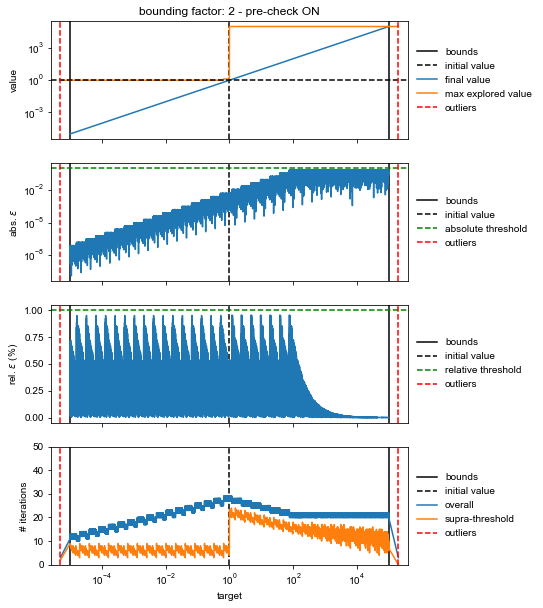

In [8]:
x0 = np.sqrt(xbounds[0] * xbounds[1])
precheck = True
fbound = 2
fig = evaluateThreshold(xref, xbounds, x0, eps_thr, rel_eps_thr, precheck, fbound)

As we can see, the pre-checking step entails pros & cons: 
- drawbacks: it adds an extra evaluation for targets within the interval, and increases the maximal evaluated value for all targets above the initial evaluation value.
- advantages: it decreases the number of evaluation to just 2 in order to find outliers. More importantly, only 1 supra-threshold evaluation is required for targets smaller than the lower bound (vs. 20+ without pre-checking)

Hence, **pre-checking should be used for searches in which there is a significant probability of thresholds being outside the search interval.**

# Specific case-studies

### E-STIM simulations

E-STIM simulations entail a few specificities:
- thresholds can vary by several orders of magnitude from neuron to neuron, hence the initial search interval upper bound must be set quite high.
- consequently, thresholds can be deemed accurate within relative error of 1%, while the absolute error does not matter much.
- supra-threshold evaluations are not necessarily computationally expensive, but they can lead to nonsense results if applied several orders of magnitude too high. However, the probability of outliers is quite low. Hence, we use pre-bounding and an initial evaluation value at 1 mA/m2, without pre-checking, in order minimize the number of supra-threshold evaluations

 29/04/2020 22:41:00: No threshold found within the [1.49e-08 - 1.00e+05] interval
C:\Users\lemaire\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater


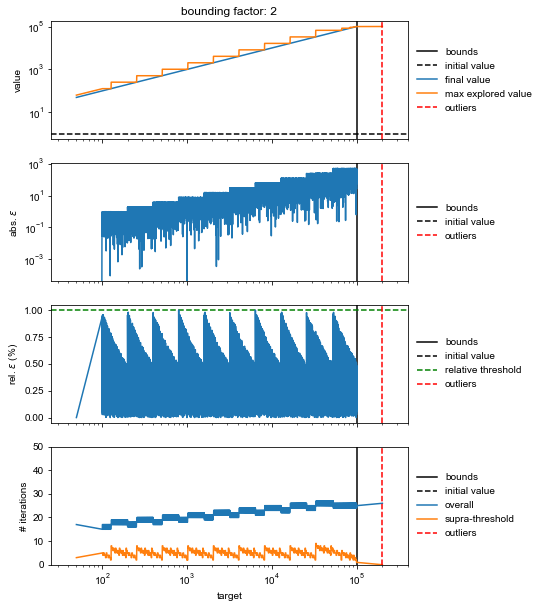

In [9]:
xbounds = (0, 1e5)    # initial search interval (mA/m2)
rel_eps_thr = 1e-2     # relative error threshold
eps_thr = None         # no absolute error threshold
precheck = False
fbound = 2
x0 = 1.0  # initial value (mA/m2)

# evaluation points
xref = np.logspace(*np.log10(np.array([(xbounds[1] - xbounds[0]) * 1e-3, xbounds[1]])), 10000)  
xref[0] /= 2
xref[-1] *= 2

fig = evaluateThreshold(xref, xbounds, x0, eps_thr, rel_eps_thr, precheck, fbound)

### A-STIM simulations

A-STIM simulations entail a few specificities:
- the search interval is always (0 - 600 kPa), hence we must adapt the algorithm to work with 0 as lower bound.
- thresholds can be deemed accurate within an absolute error of 1 kPa, while the relative error does not matter much.
- supra-threshold evaluations are very computationally expensive. Hence, we use pre-bounding in order minimize the number of supra-threshold evaluations.
- the probability of outliers is quite high, hence , we use pre-checking to handle those efficiently.
- the minimum threshold amplitude observed amongst different neuron types lies around 20-30 kPa. Hence, we use an initial evaluation value of 10 kPa in order to approach the threshold from below.

C:\Users\lemaire\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
 29/04/2020 22:41:01: No threshold found within the [5.00e-02 - 6.00e+02] interval
C:\Users\lemaire\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater
 29/04/2020 22:41:03: No threshold found within the [5.00e-02 - 6.00e+02] interval


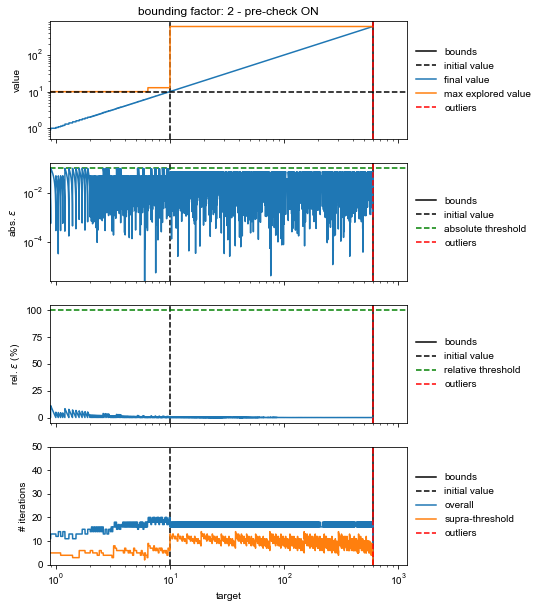

In [10]:
xbounds = (0, 600)                  # initial search interval (kPa)
x0 = ASTIM_AMP_INITIAL / 1e3        # initial value (kPa)
rel_eps_thr = ASTIM_REL_CONV_THR    # relative error threshold
eps_thr = ASTIM_ABS_CONV_THR / 1e3  # absolute error threshold (kPa)
precheck = True                     # precheck enabled
fbound = 2                          # standard bounding factor

# evaluation points
xref = np.logspace(*np.log10(np.array([(xbounds[1] - xbounds[0]) * 1e-3, xbounds[1]])), 10000)  
xref[0] -= 1
xref[-1] += 1

fig = evaluateThreshold(xref, xbounds, x0, eps_thr, rel_eps_thr, precheck, fbound)

# Conclusions

We established a robust method to search for excitation thresholds across various neuron types and stimulation modalities. This procedure:
- works efficiently over both linear and logarithmic spaces, spanning over small and large numbers of orders of magnitude, with or without zero in the interval bounds
- avoids numerous supra-threshold evaluations associated with a high computational cost
- assesses convergence thanks to absolute and / or relative criteria 
- can detect outliers very efficiently if needed (e.g. in ASTIM case)
- always returns a value satisfying the excitation condition (e.g. slightly above the approached threshold)